In [1]:
import numpy as np
from io import StringIO
import time,os, importlib
from tqdm import tqdm
np.set_printoptions(linewidth=160)
import lib.ktn_io as kio
import lib.gt_tools as gt
from scipy.sparse import save_npz,load_npz, diags, eye, csr_matrix
from scipy.sparse.linalg import eigs,inv,spsolve
from scipy.sparse.csgraph import connected_components
import scipy as sp
import scipy.linalg as spla
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm

In [2]:
data_path = "KTN_data/4S/"

beta = 1.0/5.0

Nmax = None

B, K, D, N, u, s, Emin, index_sel = kio.load_mat(path=data_path,beta=beta,Emax=None,Nmax=Nmax,screen=False)
D = np.ravel(K.sum(axis=0))
BF = beta*u-s

A_states,B_states = kio.load_AB(data_path,index_sel)

basins = B_states + A_states

inter_region = ~basins

names = ["oct","ico"]

print("\n\tN_states:",N,"N_transitions:",K.data.size)
print("\n\t%d %s STATES <-> %d %s STATES" % (A_states.sum(),names[0],B_states.sum(),names[1]))
print("\n\tbeta:",beta,"\n\n")


N,N_TS: 8 16

	N_states: 8 N_transitions: 32

	2 oct STATES <-> 2 ico STATES

	beta: 0.2 




# Hummer-Szabo implementation

In [62]:

Q = (K-diags(D)).todense()
pi = np.exp(-BF) / np.exp(-BF).sum()

mfpt = np.zeros((8,8))
for i in range(8):
    for j in range(8):
        mfpt[i][j] = -spla.solve(Q[np.arange(8)!=i,:][:,np.arange(8)!=i],(np.arange(8)==j)[np.arange(8)!=i]).sum()

kemeny = pi.dot(mfpt).mean()

iQ = np.diag(pi)@mfpt-kemeny*np.outer(pi,np.ones(8))

nu,v,w = spla.eig(Q,left=True)


iQeV = np.zeros((8,8),np.complex128)

for i in nu.argsort()[:-1]:
    print(nu[i])
    iQeV += np.outer(w[:,i],v[:,i])/nu[i]/np.dot(w[:,i],v[:,i])

print(iQeV.real@Q+np.outer(pi,np.ones(8)))
print(iQ@Q+np.outer(pi,np.ones(8)))
    
print("HH",np.abs(iQeV.real-iQ).max())
        
# Kemeny constant-
dbQ = Q.dot(np.diag(pi))



al = 1.e-6
for al in np.logspace(-15,1,16):
    res = spla.pinv(dbQ)# + al * np.ones((8,8)))*al #- np.ones((8,8))
    print(al,res.mean(),res.std()/res.mean())
    

"""
group first 2 and last 2 as A,B, rest as I
"""
n_N = 3
N = 8
M = np.zeros((N,n_N))
M[:2,0] = 1.0
M[2:-2,1] = 1.0
M[-2:,2] = 1.0

n_pi = pi@M

# H-S matrix
n_Q = np.outer(n_pi,np.ones(n_N)) - np.diag(n_pi) @ spla.inv( M.T @ spla.inv(np.outer(pi,np.ones(N))-Q) @  np.diag(pi) @ M )

piA = np.zeros(N)
piA[:2] = pi[:2]
piA /= piA.sum() 



"""
Form "first passage time" from A->B
"""
comparison = pi[-2:]@mfpt[-2:,:][:,:2]@pi[:2] / pi[-2:].sum() / pi[:2].sum()
comparison -= pi[-2:]@mfpt[-2:,:][:,-2:]@pi[-2:] / (pi[-2:].sum())**2

tau = -spla.solve(Q[np.arange(N)<N-2,:][:,np.arange(N)<N-2],piA[np.arange(N)<N-2]).sum()

n_piA = np.zeros(n_N)
n_piA[0] = 1.0 # n_pi[0]
n_tau = -spla.solve(n_Q[:-1,:][:,:-1],n_piA[:-1]).sum()
print(comparison,n_tau)


piB = np.zeros(N)
piB[-2:] = pi[-2:]
piB /= piB.sum() 

tau_sbs = np.zeros(2)
# from A to b in B
for i in range(2):
    tau_sbs[i] = -spla.solve(Q[np.arange(N)!=N-2+i,:][:,np.arange(N)!=N-2+i],piA[np.arange(N)!=N-2+i]).sum() 
    
print(tau_sbs.dot(pi[-2:])/pi[-2:].sum())



(-1.248118233848506+0j)
(-0.7015372308258608+0j)
(-0.6493077804039586+0j)
(-0.4790377499585505+0j)
(-0.39532319241321734+0j)
(-0.11239210268472369+0j)
(-0.07869078515732904+0j)
[[ 1.00000000e+00  1.87350135e-15 -3.60822483e-16 -9.15933995e-16 -4.30211422e-16 -8.46545056e-16  3.19189120e-16 -6.93889390e-17]
 [ 6.38378239e-16  1.00000000e+00  3.05311332e-16 -5.27355937e-16 -4.16333634e-16 -5.27355937e-16  1.69309011e-15  2.49800181e-16]
 [ 2.22044605e-16  2.01227923e-16  1.00000000e+00 -4.30211422e-16 -1.17961196e-16 -3.81639165e-16  1.28369537e-15  2.01227923e-16]
 [ 1.52655666e-16 -1.38777878e-17 -3.05311332e-16  1.00000000e+00 -2.77555756e-17  1.80411242e-16  6.52256027e-16  1.11022302e-16]
 [-7.21644966e-16 -2.72004641e-15  8.88178420e-16  1.38777878e-15  1.00000000e+00 -9.43689571e-16  2.16493490e-15  5.55111512e-16]
 [ 3.46944695e-17  2.56739074e-16  3.67761377e-16  8.39606162e-16  8.32667268e-17  1.00000000e+00 -1.68615122e-15 -1.46410661e-15]
 [ 5.41233725e-16  1.04083409e-15  5.

# Load Data

In [278]:
data_path = "KTN_data/LJ38/4k"

beta = 1.0/0.5 

Nmax = None

B, K, D, N, u, s, Emin, index_sel = kio.load_mat(path=data_path,beta=beta,Emax=None,Nmax=Nmax,screen=False)
D = np.ravel(K.sum(axis=0))
BF = beta*u-s

A_states,B_states = kio.load_AB(data_path,index_sel)

basins = B_states + A_states

inter_region = ~basins

names = ["oct","ico"]

print("\n\tN_states:",N,"N_transitions:",K.data.size)
print("\n\t%d %s STATES <-> %d %s STATES" % (A_states.sum(),names[0],B_states.sum(),names[1]))
print("\n\tbeta:",beta,"\n\n")



	N_states: 900 N_transitions: 2284

	5 oct STATES <-> 128 ico STATES

	beta: 2.0 




# Eigendecomposition of waiting times

oct -> ico : (312761.32555937057, 2841030266.168343) (312761.09939185996, 312761.09939185996)
ico -> oct : (11817.652379295487, 2836940967.887002) (11817.652380115684, 11817.652380115684)


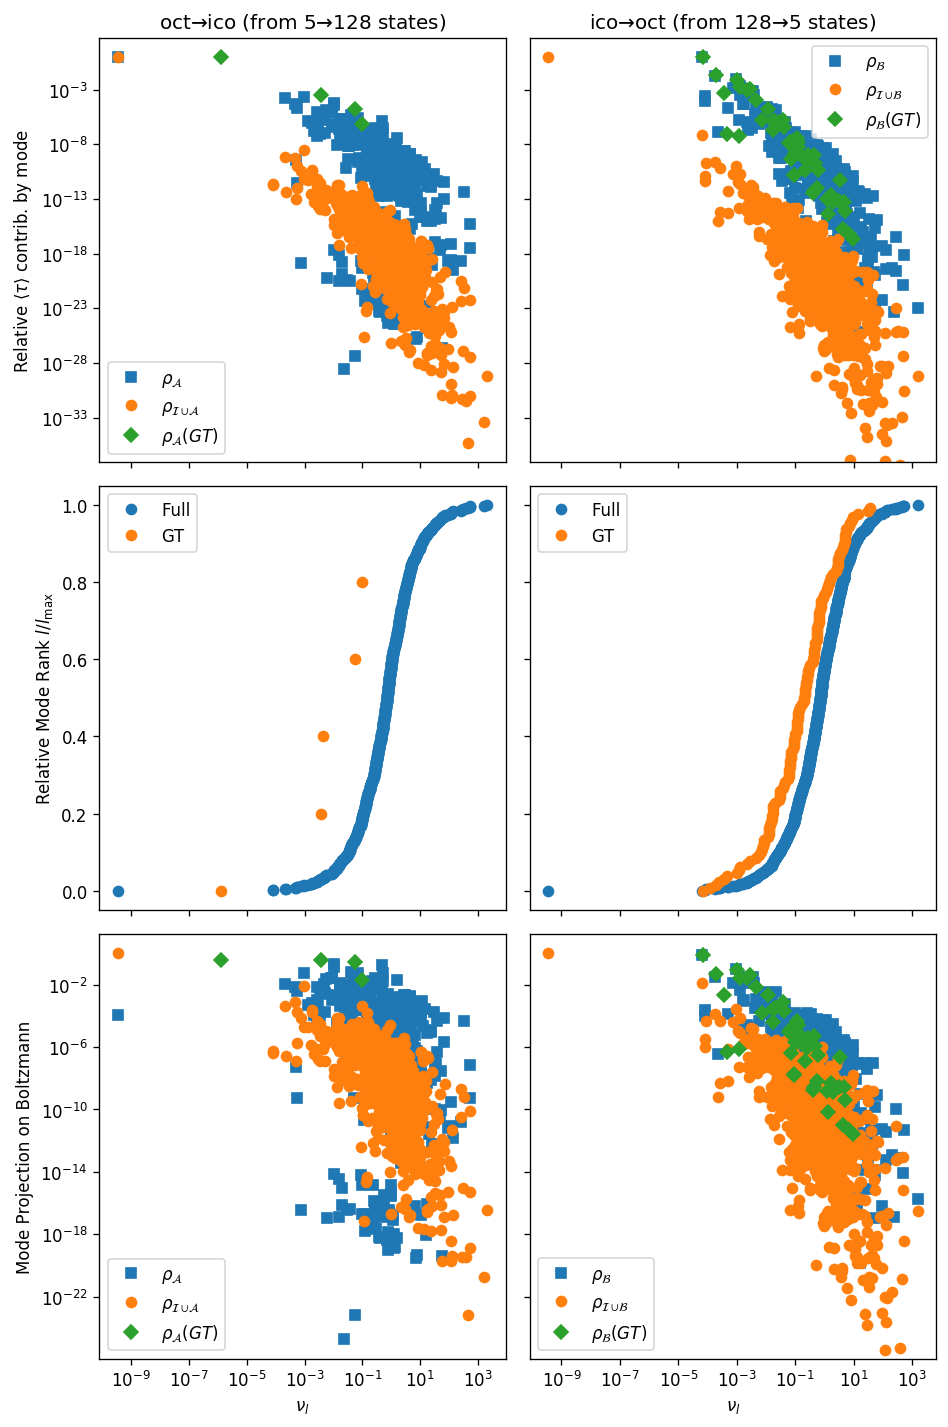

In [279]:
fig, ax = plt.subplots(3,2,figsize=(8,12),dpi=120,sharey='row',sharex='col')

Q = (diags(D)-K).todense()

rho = np.exp(-BF)
sel = [~A_states,~B_states]
r_sel = [~A_states[~inter_region],~B_states[~inter_region]]
for j in [0,1]:
    
    rho = np.exp(-BF).copy()
    
    rho[sel[j]] = 0.0 # 
    
    rho = rho[sel[1-j]] / rho[sel[1-j]].sum()
    
    
    nu,v,w = sp.linalg.eig(Q[sel[1-j],:][:,sel[1-j]],left=True,right=True)
    
    wp = np.r_[[w[:,i].real.sum()/np.sqrt(w[:,i].dot(v[:,i])) for i in nu.real.argsort()]]
    
    vp = np.r_[[v[:,i].real.dot(rho)/np.sqrt(w[:,i].dot(v[:,i])) for i in nu.real.argsort()]]
    nup = nu[nu.real.argsort()].real
    
    rho = np.exp(-BF).copy()
    rho = rho[sel[1-j]] / rho[sel[1-j]].sum()
    
    vpf = np.r_[[v[:,i].real.dot(rho)/np.sqrt(w[:,i].dot(v[:,i])) for i in nu.real.argsort()]]
    
    tau = (wp*vp/nup).sum(),(wp*vpf/nup).sum()
    
    
    ax[0,j].plot(nup,wp*vp/nup/tau[0],'s',label=r"$\rho_\mathcal{%s}$" % ['A','B'][j])
    ax[0,j].plot(nup,wp*vpf/nup/tau[1],'o',label=r"$\rho_\mathcal{I\cup %s}$" % ['A','B'][j])
    
    ax[2,j].plot(nup,wp*vp,'s',label=r"$\rho_\mathcal{%s}$" % ['A','B'][j])
    ax[2,j].plot(nup,wp*vpf,'o',label=r"$\rho_\mathcal{I\cup %s}$" % ['A','B'][j])
    
    #ax[1,j].plot(nup,tau[0]*np.ones(nup.size),'k--',label=r'$\langle\tau\rangle$') #np.linspace(0.,1.0,nup.size),'o')

    #ax[1,j].plot(nup,1.0/nup,'o',label='full')#np.linspace(0.,1.0,nup.size),'o')
    ax[1,j].plot(nup,np.arange(nup.size)/nup.size,'o',label='Full')
    
    r_Q = gt.gt_seq(N=N,rm_reg=inter_region,B=B,D=D,trmb=50,retK=True,Ndense=50,screen=False)[2].todense()
    
    
    
    r_rho = np.exp(-BF[~inter_region]).copy()
    r_rho[r_sel[j]] = 0.0
    r_rho = r_rho[r_sel[1-j]] / r_rho[r_sel[1-j]].sum()
    
    nu,v,w = sp.linalg.eig(r_Q[r_sel[1-j],:][:,r_sel[1-j]],left=True,right=True)
    wp = np.r_[[w[:,i].real.sum()/np.sqrt(w[:,i].dot(v[:,i])) for i in nu.real.argsort()]]
    vp = np.r_[[v[:,i].real.dot(r_rho)/np.sqrt(w[:,i].dot(v[:,i])) for i in nu.real.argsort()]]
    nup = nu[nu.real.argsort()].real
    
    r_rho = np.exp(-BF[~inter_region]).copy()
    r_rho = r_rho[r_sel[1-j]] / r_rho[r_sel[1-j]].sum()
    
    vpf = np.r_[[v[:,i].real.dot(r_rho)/np.sqrt(w[:,i].dot(v[:,i])) for i in nu.real.argsort()]]
    
    r_tau = (wp*vp/nup).sum(),(wp*vpf/nup).sum()
    
    print("%s -> %s :" % (names[j],names[1-j]),tau,r_tau)#,x.sum())
    
    ax[0,j].plot(nup,wp*vp/nup/tau[0],'D',label=r"$\rho_\mathcal{%s} (GT)$" % ['A','B'][j])
    
    #ax[1,j].plot(nup,1.0/nup,'o',label='GT') #np.linspace(0.,1.0,nup.size),'o')
    
    ax[1,j].plot(nup,np.arange(nup.size)/nup.size,'o',label='GT')
    
    ax[2,j].plot(nup,wp*vp,'D',label=r"$\rho_\mathcal{%s} (GT)$" % ['A','B'][j])
    
    ax[0,j].legend()#
    ax[1,j].legend()#
    ax[2,j].legend()#
    #ax[2,j].legend(loc="lower left")
    
    ax[0,j].set_yscale("log")
    #ax[1,j].set_yscale("log")
    ax[2,j].set_yscale("log")
    
    ax[0,j].set_xscale("log")
    ax[1,j].set_xscale("log")
    
    #ax[1,j].set_ylim(1.0e5,1.0e9)
    
    ax[0,j].set_title(r"%s$\to$%s (from %d$\to$%d states)" % (names[j],names[1-j],(~sel[j]).sum(),(~sel[1-j]).sum()))
    ax[2,j].set_xlabel(r"$\nu_l$")
    
    

ax[0,0].set_ylabel(r"Relative $\langle\tau\rangle$ contrib. by mode")#$({\rm1}\cdot{\rm w}_l)({\rm v}_l\cdot{\rho})/\nu_l/\langle\tau\rangle$")
ax[1,0].set_ylabel(r"Relative Mode Rank $l/l_{\rm max}$")#Eigenvalue $\nu_l$Relaxation Time $\nu^{-1}_l$")
ax[2,0].set_ylabel(r"Mode Projection on Boltzmann")

plt.tight_layout()

# Waiting time distribution

oct -> ico : (312761.32555937057, 2841030266.168343)  /=GT -> : 1.0000007231318442
ico -> oct : (11817.652379295489, 2836940967.887002)  /=GT -> : 0.9999999999305955


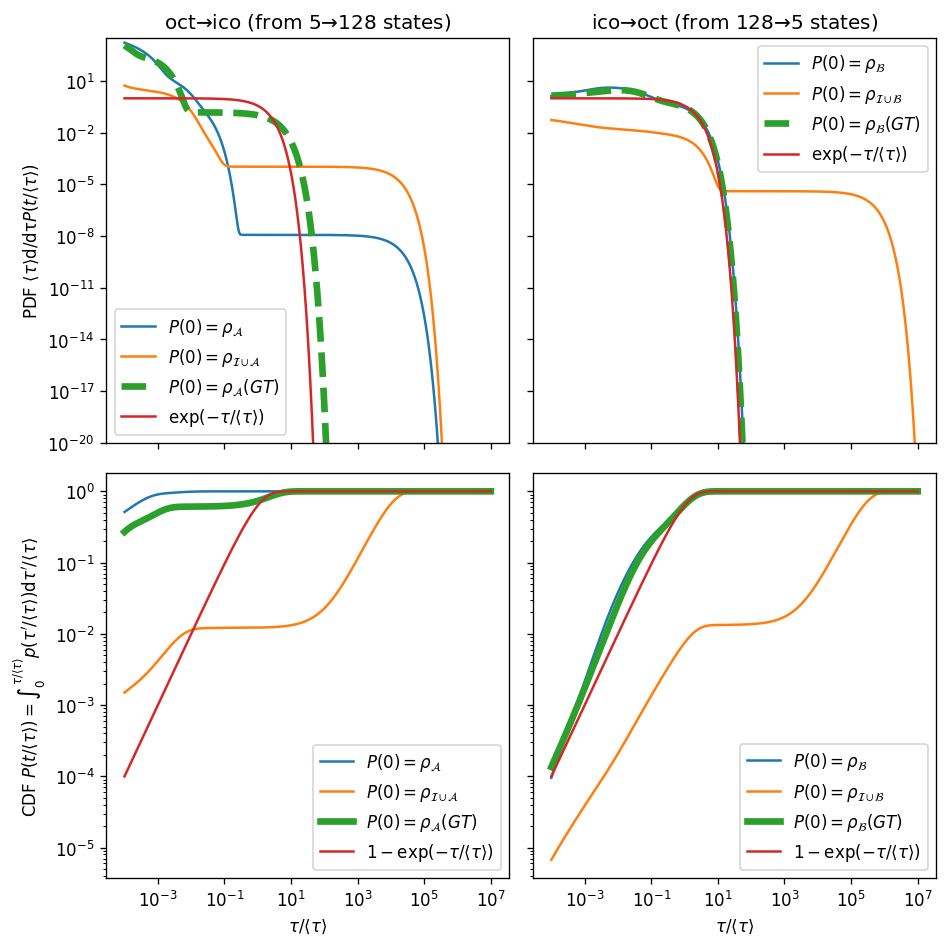

In [284]:
fig, ax = plt.subplots(2,2,figsize=(8,8),dpi=120,sharex='col',sharey='row')

Q = (diags(D)-K).todense()

rho = np.exp(-BF)
sel = [~A_states,~B_states]

ymax=1.0 # (exp)
r_sel = [~A_states[~inter_region],~B_states[~inter_region]]
for j in [0,1]:
    
    rho_I = np.exp(-BF)[sel[1-j]] / np.exp(-BF)[sel[1-j]].sum()
    rho = (rho_I * ~sel[j][sel[1-j]]) / (rho_I * ~sel[j][sel[1-j]]).sum()
        
    nu,v,w = sp.linalg.eig(Q[sel[1-j],:][:,sel[1-j]],left=True,right=True)
    
    vp = np.r_[[v[:,i].real.dot(rho)/np.sqrt(w[:,i].dot(v[:,i])) for i in nu.real.argsort()]]
    wp = np.r_[[w[:,i].real.sum()/np.sqrt(w[:,i].dot(v[:,i])) for i in nu.real.argsort()]]
    vpf = np.r_[[v[:,i].real.dot(rho_I)/np.sqrt(w[:,i].dot(v[:,i])) for i in nu.real.argsort()]]
    nup = nu[nu.real.argsort()].real
    
    tau = (wp*vp/nup).sum(),(wp*vpf/nup).sum()
    ta = np.logspace(-4,7,1000)*tau[0]
    
    
    # PDF
    y = np.exp(-np.outer(ta,nup)).dot(wp*vp*nup)*tau[0]
    ax[0,j].plot(ta/tau[0],y,'-',label=r"$P(0)=\rho_\mathcal{%s}$" % ['A','B'][j])
    ymax = max(ymax,y.max())
    
    # PDF from +=I
    y = np.exp(-np.outer(ta,nup)).dot(wp*vpf*nup)*tau[0]
    ax[0,j].plot(ta/tau[0],y,'-',label=r"$P(0)=\rho_\mathcal{I\cup %s}$" % ['A','B'][j])
    ymax = max(ymax,y.max())
    
    
    ax[1,j].plot(ta/tau[0],1.0-np.exp(-np.outer(ta,nup)).dot(wp*vp),'-',label=r"$P(0)=\rho_\mathcal{%s}$" % ['A','B'][j])
    ax[1,j].plot(ta/tau[0],1.0-np.exp(-np.outer(ta,nup)).dot(wp*vpf),'-',label=r"$P(0)=\rho_\mathcal{I\cup %s}$" % ['A','B'][j])
    
    
    r_Q = gt.gt_seq(N=N,rm_reg=inter_region,B=B,D=D,trmb=50,retK=True,Ndense=50,screen=False)[2].todense()
    
    r_rho_I = np.exp(-BF[~inter_region])[r_sel[1-j]] / np.exp(-BF[~inter_region])[r_sel[1-j]].sum()
    r_rho = (r_rho_I * ~r_sel[j][r_sel[1-j]]) / (r_rho_I * ~r_sel[j][r_sel[1-j]]).sum()
    
    
    nu,v,w = sp.linalg.eig(r_Q[r_sel[1-j],:][:,r_sel[1-j]],left=True,right=True)
    wp = np.r_[[w[:,i].real.sum()/np.sqrt(w[:,i].dot(v[:,i])) for i in nu.real.argsort()]]
    vp = np.r_[[v[:,i].real.dot(r_rho)/np.sqrt(w[:,i].dot(v[:,i])) for i in nu.real.argsort()]]
    vpf = np.r_[[v[:,i].real.dot(r_rho_I)/np.sqrt(w[:,i].dot(v[:,i])) for i in nu.real.argsort()]]
    nup = nu[nu.real.argsort()].real
    
    r_tau = (wp*vp/nup).sum(),(wp*vpf/nup).sum()
    
    print("%s -> %s :" % (names[j],names[1-j]),tau," /=GT -> :",tau[0]/r_tau[0])#,x.sum())
    
    # PDF from GT
    y = np.exp(-np.outer(ta,nup)).dot(wp*vp*nup)*tau[0]
    ax[0,j].plot(ta/tau[0],y,'--',label=r"$P(0)=\rho_\mathcal{%s} (GT)$" % ['A','B'][j],lw=4)
    ymax = max(ymax,y.max())
        
    ax[1,j].plot(ta/tau[0],1.0-np.exp(-np.outer(ta,nup)).dot(wp*vp),'-',label=r"$P(0)=\rho_\mathcal{%s} (GT)$" % ['A','B'][j],lw=4)
    
    # Single exp.
    ax[0,j].plot(ta/tau[0],np.exp(-ta/r_tau[0]),'-',label=r"$\exp(-\tau/\langle\tau\rangle)$")
    #ax[0,j].plot(ta/tau[0],np.exp(-ta/tau[1]),'-',label=r"$\exp(-\tau/\langle\tau\rangle_{\cup\mathcal{I}})$")
    
    
    ax[1,j].plot(ta/tau[0],1.0-np.exp(-ta/r_tau[0]),'-',label=r"$1-\exp(-\tau/\langle\tau\rangle)$")
    
    
    ax[0,j].legend()#ncol=2)#loc="lower center")
    ax[1,j].legend()#ncol=2)#loc="lower center")
    ax[0,j].set_yscale("log")
    ax[0,j].set_xscale("log")
    ax[1,j].set_yscale("log")
    ax[1,j].set_xscale("log")
    ax[0,j].set_title(r"%s$\to$%s (from %d$\to$%d states)" % (names[j],names[1-j],(~sel[j]).sum(),(~sel[1-j]).sum()))
    ax[0,j].set_ylim(ymin=1.0e-20,ymax=2.0*ymax)#,1.0e2)
    

ax[0,0].set_ylabel(r"PDF $\langle\tau\rangle{\rm d}/{\rm d\tau}P(t/\langle\tau\rangle)$")
ax[1,0].set_xlabel(r"$\tau/\langle\tau\rangle$")
ax[1,1].set_xlabel(r"$\tau/\langle\tau\rangle$")
ax[1,0].set_ylabel(r"CDF $P(t/\langle\tau\rangle) = \int_0^{\tau/\langle\tau\rangle} p(\tau'/\langle\tau\rangle) {\rm d}\tau'/\langle\tau\rangle$")

plt.tight_layout()

# Now try finding metastable basins.... first in $\mathcal{B}\equiv\texttt{ico}$ 

4 73 30 56 1 74.21473069462334
5 71 32 54 1 74.89723094882616
6 59 41 43 1 72.87130850189943
7 49 59 36 1 7.83395961928933
8 46 61 32 1 7.833964869133899
9 44 72 32 1 7.839104990347686
10 39 78 28 1 7.844298029789237
11 37 82 27 3 7.844258343482409
thresh =  6.0


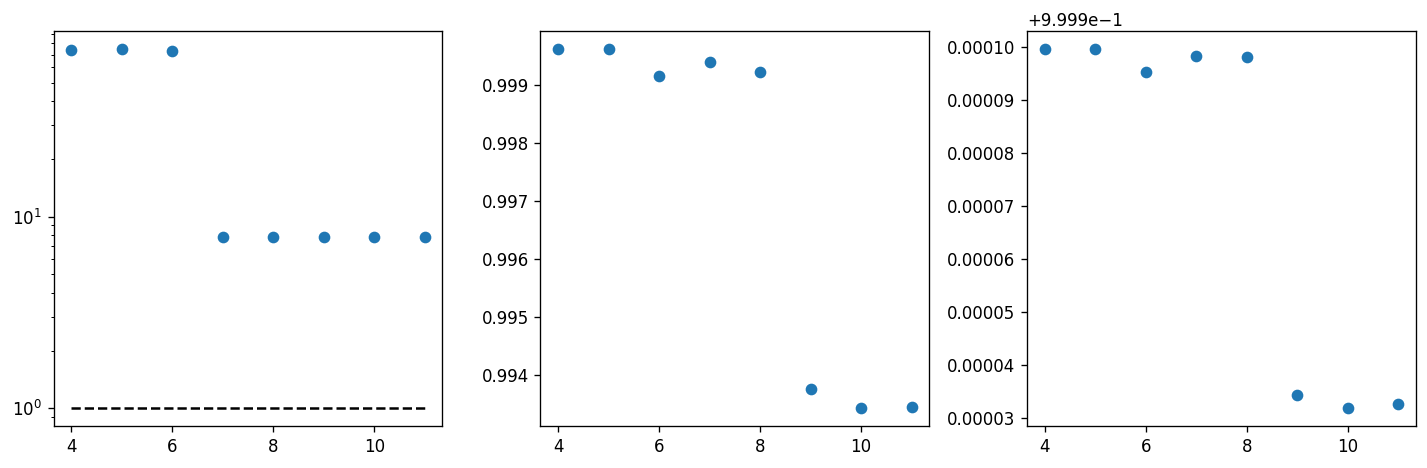

In [194]:
fig,ax = plt.subplots(1,3,figsize=(12,4),dpi=120)
sel = B_states

ico_D = diags(D[sel])
ico_K = K[sel,:][:,sel].copy()
ico_K.eliminate_zeros()

rho = np.exp(-BF[sel])

thra = np.arange(4,12)
tt = np.zeros((thra.size,5))
for j,thresh in enumerate(thra):
    
    tK = ico_K.copy()
    tK.data = -np.log(tK.data)

    tK.data[tK.data>thresh] = 0.0
    tK.eliminate_zeros()
    
    nc,cc = connected_components(tK)
    
    counts = np.bincount(cc)
    bc = cc == counts.argmax()
    
    btK = (ico_D-ico_K)[bc,:][:,bc]
    
    brho = rho[bc] / rho[bc].sum()
    
    nu,v,w = spla.eig(btK.todense(),left=True)
    
    wp = np.r_[[w[:,i].real.sum()/np.sqrt(w[:,i].dot(v[:,i])).real for i in nu.real.argsort()]]
    wp *= np.r_[[v[:,i].real.dot(brho)/np.sqrt(w[:,i].dot(v[:,i])).real for i in nu.real.argsort()]]
    nup = nu[nu.real.argsort()].real
    gaps = nup[1:]/nup[:-1]
    
    print(thresh,nc,counts.max(),(counts==1).sum(),gaps.argmax(),gaps.max())
    tau = (wp/nup).sum()
    #ax[2].loglog(nup[:gaps.argmax()+1],wp[:gaps.argmax()+1]/nup[:gaps.argmax()+1]/tau,'o')
    
    tt[j] = [thresh,gaps.max(),wp[:gaps.argmax()+1].sum(),rho[bc].sum()/rho.sum(),(wp[:gaps.argmax()+1]/nup[:gaps.argmax()+1]/tau).sum()]
    """
    if j==0:
        ax[0].loglog(nup[:5],nup[:5],'k--')    
    ax[0].loglog(nup[:4],nup[1:5],'o')
    """
ax[0].semilogy(tt[:,0],tt[:,1],'o')
ax[0].semilogy(tt[:,0],tt[:,0]*0.0 + 1.0,'k--')
ax[1].plot(tt[:,0],tt[:,2],'o')
ax[2].plot(tt[:,0],tt[:,4],'o')

plt.tight_layout()

selthresh = 6.0
print("thresh = ",selthresh)

# Make this recursive

In [240]:

def cg_thresh(_K,_D,_rho,_thresh):
    
    myK = _K.copy()
    myD = _D.copy()
    myrho = _rho.copy()
    
    lK = myK.copy()
    lK.data = -np.log(lK.data)

    lK.data[lK.data>_thresh] = 0.0
    lK.eliminate_zeros()
    nc,cc = connected_components(lK)
    
    counts = np.bincount(cc)
    bc = cc == counts.argmax() # largest cluster
    
    btK = (myD-myK)[bc,:][:,bc]
    
    brho = myrho[bc] / myrho[bc].sum()
    
    nu,v,w = spla.eig(btK.todense(),left=True)
    dp = np.sqrt(np.diagonal(w.T.dot(v))).real
    v = (v.real.dot(np.diag(1.0/dp)))
    w = (w.real.dot(np.diag(1.0/dp)))
    nu = nu.real
    
    
    # Currently using tau proportion for rank - anything is OK providing w,v have the same ordering
    
    tauv = (w.sum(axis=0) * v.T.dot(brho) /nu)
    tauv /= tauv.sum()
    
    ranking = tauv.argsort()[::-1] # nu.argsort()
    
    nm = (tauv[ranking].cumsum()>0.99).argmax()+1 # gaps = nu[1:] / nu[:-1]
    
    #print((tauv[tauv.argsort()[::-1]].cumsum()>0.99).argmax(),gaps.argmax(),gaps.max(),nu.size)
    
    nm = gaps.argmax()+1
    
    return tauv[ranking][:nm].sum() / tauv.sum(), nu[ranking][:nm],v[:,:nm],w[:,:nm], bc



def find_thresh_and_split(_K,_D,_rho,thra=np.linspace(2.0,50.0,49)):
    S = np.zeros(_K.size)
    
    for th in thra:
        prop_tau, nu, v, w, bc = cg_thresh(_K,_D,_rho,th)
        
        if prop_tau>0.99: # this is the "true" threshold
            break
    
    
    nN = (~bc).sum() + nu.size # new rank
    
    print(_K.shape[0],nN)
    
    S = np.block([v.T,np.zeros(((~bc).sum(),nN))])
    T = np.block([w,np.zeros((nN,(~bc).sum()))])
    
    print(S.dot(K).dot(T).shape)
    
    
    return th, gap, prop_tau, nu, v, w
    
    """
    
        zero(_K.shape[0])
    T = np.identity(_K.shape[0])
    S[bc,:] = v.T.copy()
    T[:,bc] = w.copy()
    
    S.dot(_K).dot(T)
    
    """
    
    # res = gaps.max(),tau_prop, nu, v, w
    # v.K, w.K
    
    
        

res = find_thresh_and_split(ico_K,ico_D,rho)
print(res[0],res[1],res[2],res[3].size)

1 1 65.87088001163791 22
1 1 68.8291348591168 23
1 1 74.21473069462334 30
1 1 74.89723094882616 32
1 1 72.87130850189943 41
1 1 7.83395961928933 59
1 1 7.833964869133899 61
1 1 7.839104990347686 72
1 1 7.844298029789237 78
2 3 7.844258343482409 82
3 4 7.844234773517929 84
3 5 4.930681709084762 90
3 5 4.930681709084762 90
3 7 4.930681667288879 95
3 7 4.930681667288879 95
3 7 4.930681667288879 95
3 7 4.930681667288879 95
3 7 4.930681667288879 95
3 7 4.930681667288879 95
3 7 4.930681667288879 95
4 0 1402.5866800650988 96
4 0 1402.5866800650988 96
4 0 1402.5866800650988 96
4 0 1402.5866800650988 96
4 0 1402.5866800650988 96
4 0 1402.5866800650988 96
4 0 1402.5866800650988 96
4 0 1402.5866800650988 96
4 0 1402.5866800650988 96
4 0 1402.5866800650988 96
4 0 1402.5866800650988 96
4 0 1402.5866800650988 96
4 0 1402.5866800650988 96
4 0 1402.5866800650988 96
4 0 1402.5866800650988 96
4 0 1402.5866800650988 96
4 0 1402.5866800650988 96
4 0 1402.5866800650988 96
4 0 1402.5866800650988 96
4 0 1402

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1 and the array at index 1 has size 32

In [242]:
(np.arange(17)>3).argmax()

4

# One dimensional 4 state (A-D) example- A absorbing and can only be accessed from B

# But, $k_{A\leftarrow B} > k_{B\leftarrow C}$, so escape is not the slowest process

[ 4.88165601e-01  5.11834420e-01  2.52486777e-08 -4.56969493e-08  0.00000000e+00  3.30106540e-12  2.05024316e-13] [4.24906272e-15 1.52293933e-05 3.71453866e-02 5.80202636e-02 1.81435907e-01 2.59955823e-01 5.37624700e-01]


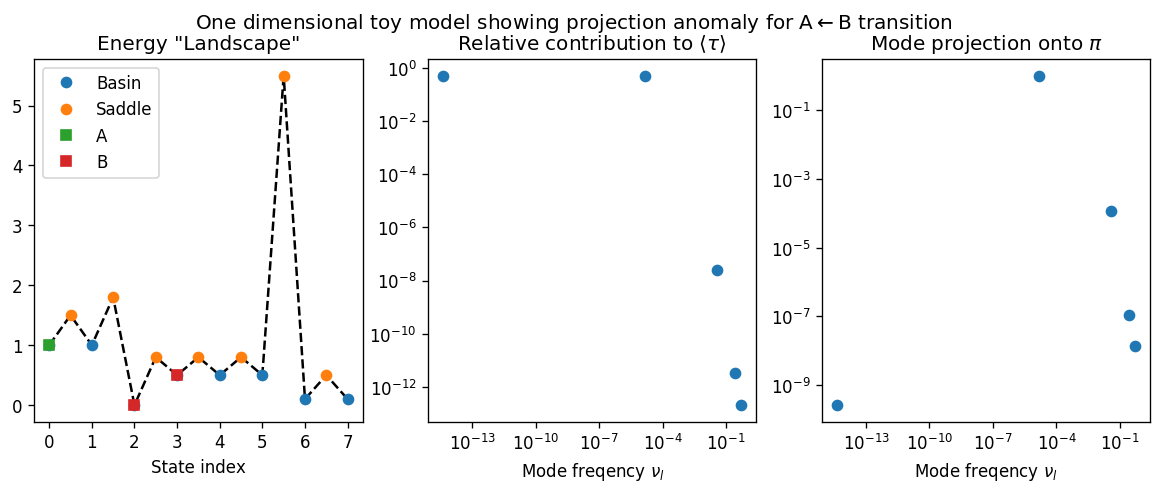

In [156]:
from scipy.interpolate import interp1d
fig, ax = plt.subplots(1,3,figsize=(12,4),dpi=120)#,sharey='row',sharex='col')

beta = 6.0

# index%2==0 -> states, else saddle
E = np.r_[[1.0,1.5,1.0,1.8,0.0,0.8,0.5,0.8,0.5,0.8,0.5,5.5,0.1,0.5,0.1,0.5]]

tE = E.reshape((-1,2))





spl = interp1d(np.arange(E.size-1),E[:-1],kind='linear')
x = np.linspace(0.,np.arange(E.size)[-2],501)
ax[0].plot(x,spl(x),'k--')
ax[0].plot(np.arange(tE.shape[0])*2,tE[:,0],'o',label='Basin')
ax[0].plot(np.arange(tE.shape[0]-1)*2+1,tE[:-1,1],'o',label='Saddle')

ax[0].plot(np.zeros(1,int),np.r_[tE[0,0]],'s',label='A')




N = tE.shape[0]

Q = np.zeros((N,N))
for i in range(N):
    if i>0:
        Q[i-1][i] = np.exp(-(tE[i-1][1]-tE[i][0])*beta)
    if i<N-1:
        Q[i+1][i] = np.exp(-(tE[i][1]-tE[i][0])*beta)

#ax[2].matshow(Q,cmap="Spectral")    

for i in range(N):
    Q[i][i] = -Q[:,i].sum()

Q*=-1.0

sel = np.ones(N,bool)

sel[0]=False

rho = np.zeros(N)

selB = np.r_[[2,3]].astype(int)

ax[0].plot(selB*2,tE[selB,0],'s',label='B')
rho[selB] = np.exp(-tE[selB,0]*beta) / np.exp(-tE[selB,0]*beta).sum()


nu,v,w = sp.linalg.eig(Q[sel,:][:,sel],left=True,right=True)

wp = np.r_[[w[:,i].real.sum()/np.sqrt(w[:,i].dot(v[:,i])) for i in nu.real.argsort()]]

vp = np.r_[[v[:,i].real.dot(rho[sel])/np.sqrt(w[:,i].dot(v[:,i])) for i in nu.real.argsort()]]

nup = nu[nu.real.argsort()].real

tau = (wp*vp/nup).sum()

tauc = (wp*vp/nup/tau)

print(tauc,nup)

ax[0].set_title("Energy \"Landscape\"")
ax[0].legend()


ax[1].set_title(r"Relative contribution to $\langle\tau\rangle$")
ax[2].set_title(r"Mode projection onto $\pi$")
ax[1].set_xlabel(r"Mode freqency $\nu_l$")
ax[2].set_xlabel(r"Mode freqency $\nu_l$")

ax[0].set_xlabel(r"State index")
ax[0].set_xticks(np.arange(N)*2)
ax[0].set_xticklabels([str(n) for n in np.arange(N)])


ax[1].loglog(nup,tauc,'o')
ax[2].loglog(nup,vp*wp,'o')

fig.suptitle(r"One dimensional toy model showing projection anomaly for A$\leftarrow$B transition")


plt.savefig("toy_model_anomaly.pdf")


